In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os

ruta_datos = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES"

if os.path.exists(ruta_datos):
    print("Ruta encontrada")
else:
    print("La ruta NO existe, revisa el nombre exacto")



Ruta encontrada


In [3]:
for raiz, carpetas, archivos in os.walk(ruta_datos):
    print(f"\n Carpeta: {raiz}")
    for c in carpetas:
        print("    Subcarpeta:", c)
    for a in archivos:
        print("    Archivo:", a)



 Carpeta: /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES
    Subcarpeta: ejemplos_patches_unet
    Subcarpeta: patches_ejemplo_DeepLab
    Archivo: Municipios_ValledeAburra.prj
    Archivo: Municipios_ValledeAburra.dbf
    Archivo: Municipios_ValledeAburra.cpg
    Archivo: Municipios_ValledeAburra.shx
    Archivo: Municipios_ValledeAburra.qmd
    Archivo: Municipios_ValledeAburra.shp
    Archivo: ValleAburraSimplificado.qmd
    Archivo: ValleAburraSimplificado.dbf
    Archivo: ValleAburraSimplificado.prj
    Archivo: ValleAburraSimplificado.cpg
    Archivo: ValleAburraSimplificado.shx
    Archivo: ValleAburraSimplificado.shp
    Archivo: NDVI_2023.tif
    Archivo: NDVI_2023.tif.aux.xml
    Archivo: Landsat8_2023-03-22.tif
    Archivo: Landsat8_2016-05-21.tif
    Archivo: Landsat8_2017-12-18.tif
    Archivo: Landsat8_2023-02-02.tif
    Archivo: Landsat8_2020-01-09(1).tif
    Archivo: Landsat8_2019-07-17.tif
    Archivo: Landsat

In [4]:
import pandas as pd

inventario = []

for raiz, carpetas, archivos in os.walk(ruta_datos):
    for archivo in archivos:
        ruta_completa = os.path.join(raiz, archivo)
        extension = archivo.split('.')[-1].lower()

        inventario.append({
            "carpeta": raiz.replace(ruta_datos, ""),
            "archivo": archivo,
            "extension": extension,
            "ruta_completa": ruta_completa
        })

df_inv = pd.DataFrame(inventario)
df_inv.head()


,carpeta,archivo,extension,ruta_completa
0,,Municipios_ValledeAburra.prj,prj,/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS...
1,,Municipios_ValledeAburra.dbf,dbf,/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS...
2,,Municipios_ValledeAburra.cpg,cpg,/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS...
3,,Municipios_ValledeAburra.shx,shx,/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS...
4,,Municipios_ValledeAburra.qmd,qmd,/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS...


In [5]:
output_path = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/inventario_datos_tesis.xlsx"
df_inv.to_excel(output_path, index=False)

print("Inventario guardado en:", output_path)


Inventario guardado en: /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/inventario_datos_tesis.xlsx


# MODELO 1 – BASELINE NDVI–NDBI (UMBRAL ESPECTRAL)

In [6]:
import os
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling

base = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES"


ndvi_path = os.path.join(base, "NDVI_2023_32618_30m.tif")
ndbi_path = os.path.join(base, "ndbi_clasificado.tif")


with rasterio.open(ndvi_path) as ndvi_src:
    ndvi = ndvi_src.read(1)
    ndvi_profile = ndvi_src.profile
    ndvi_nodata = ndvi_src.nodata
    print("NDVI shape:", ndvi.shape)


with rasterio.open(ndbi_path) as ndbi_src:
    ndbi = ndbi_src.read(1)
    print("NDBI shape:", ndbi.shape)
    ndbi_nodata = ndbi_src.nodata


ndbi_resampled = np.full_like(ndvi, fill_value=ndbi_nodata if ndbi_nodata is not None else -9999)

reproject(
    source=ndbi,
    destination=ndbi_resampled,
    src_transform=ndbi_src.transform,
    src_crs=ndbi_src.crs,
    dst_transform=ndvi_profile["transform"],
    dst_crs=ndvi_profile["crs"],
    src_nodata=ndbi_nodata,
    dst_nodata=ndbi_nodata if ndbi_nodata is not None else -9999,
    resampling=Resampling.nearest
)

print("NDBI reproyectado shape:", ndbi_resampled.shape)

NDVI shape: (2294, 4209)
NDBI shape: (5904, 5502)
NDBI reproyectado shape: (2294, 4209)


Definición de reglas de clasificación

In [7]:
ndvi_urbano_max = 0.25
ndbi_urbano_min = 2


valid_mask = (~np.isnan(ndvi)) & (ndvi != ndvi_nodata)


urbano_baseline = np.zeros_like(ndvi, dtype=np.uint8)


urbano_baseline[(ndvi <= ndvi_urbano_max) & (ndbi_resampled >= ndbi_urbano_min) & valid_mask] = 1


out_path = os.path.join(base, "urbano_baseline_2023.tif")
out_profile = ndvi_profile.copy()
out_profile.update(dtype="uint8", count=1, nodata=0)

with rasterio.open(out_path, "w", **out_profile) as dst:
    dst.write(urbano_baseline, 1)

print("Mapa urbano/no urbano baseline guardado como:", out_path)

Mapa urbano/no urbano baseline guardado como: /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/urbano_baseline_2023.tif


# MODELO 2 – RANDOM FOREST POR PÍXEL

Preparar matriz de datos (X, y)

In [8]:
import rasterio
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

ndvi_path = os.path.join(base, "NDVI_2023_32618_30m.tif")
lst_path  = os.path.join(base, "LST_2023_Reproyectado.tif")
ndbi_path = os.path.join(base, "ndbi_clasificado.tif")
y_path    = os.path.join(base, "urbano_baseline_2023.tif")

with rasterio.open(ndvi_path) as src:
    ndvi = src.read(1).astype(float)
    ref_profile = src.profile
    ndvi_nodata = src.nodata
    transform_ref = src.transform
    crs_ref = src.crs

with rasterio.open(lst_path) as src:
    lst = src.read(1).astype(float)
    lst_nodata = src.nodata
    print("LST shape:", lst.shape, "| NDVI shape:", ndvi.shape)

if lst.shape != ndvi.shape:
    from rasterio.warp import reproject, Resampling
    lst_resampled = np.full_like(ndvi, fill_value=lst_nodata if lst_nodata is not None else -9999)
    reproject(
        source=lst,
        destination=lst_resampled,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform_ref,
        dst_crs=crs_ref,
        src_nodata=lst_nodata,
        dst_nodata=lst_nodata if lst_nodata is not None else -9999,
        resampling=Resampling.bilinear
    )
    lst = lst_resampled


with rasterio.open(ndbi_path) as src:
    ndbi = src.read(1).astype(float)
    ndbi_nodata = src.nodata
    transform_ndbi = src.transform
    crs_ndbi = src.crs

from rasterio.warp import reproject, Resampling

ndbi_resampled = np.full_like(ndvi, fill_value=ndbi_nodata if ndbi_nodata is not None else -9999)

reproject(
    source=ndbi,
    destination=ndbi_resampled,
    src_transform=transform_ndbi,
    src_crs=crs_ndbi,
    dst_transform=transform_ref,
    dst_crs=crs_ref,
    src_nodata=ndbi_nodata,
    dst_nodata=ndbi_nodata if ndbi_nodata is not None else -9999,
    resampling=Resampling.nearest
)


with rasterio.open(y_path) as src:
    y_raster = src.read(1).astype(int)
    y_nodata = src.nodata if src.nodata is not None else 0

print("Shapes:", ndvi.shape, lst.shape, ndbi_resampled.shape, y_raster.shape)


LST shape: (2294, 4209) | NDVI shape: (2294, 4209)
Shapes: (2294, 4209) (2294, 4209) (2294, 4209) (2294, 4209)


Construir X, y (aplanar y filtrar NoData)

In [9]:

valid_mask = (
    (~np.isnan(ndvi)) & (ndvi != ndvi_nodata) &
    (~np.isnan(lst))  & (lst != lst_nodata) &
    (~np.isnan(ndbi_resampled)) & (ndbi_resampled != ndbi_nodata) &
    (y_raster != y_nodata)
)

print("N píxeles válidos:", valid_mask.sum())


ndvi_flat = ndvi[valid_mask].reshape(-1, 1)
lst_flat  = lst[valid_mask].reshape(-1, 1)
ndbi_flat = ndbi_resampled[valid_mask].reshape(-1, 1)

X = np.concatenate([ndvi_flat, lst_flat, ndbi_flat], axis=1)
y = y_raster[valid_mask].ravel()

print("X shape:", X.shape, "| y shape:", y.shape)


N píxeles válidos: 110766
X shape: (110766, 3) | y shape: (110766,)


In [10]:

N_max = 100000   # por ejemplo
if X.shape[0] > N_max:
    idx = np.random.choice(X.shape[0], N_max, replace=False)
    X_sample = X[idx]
    y_sample = y[idx]
else:
    X_sample = X
    y_sample = y

print("Muestra usada para RF:", X_sample.shape[0], "píxeles")


Muestra usada para RF: 100000 píxeles


Entrenar Random Forest y evaluar

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.3, random_state=42, stratify=y_sample
)

print("Train:", X_train.shape[0], " | Test:", X_test.shape[0])


rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)

print("Resultados Random Forest:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))


Train: 70000  | Test: 30000
Resultados Random Forest:
[[30000]]
              precision    recall  f1-score   support

           1      1.000     1.000     1.000     30000

    accuracy                          1.000     30000
   macro avg      1.000     1.000     1.000     30000
weighted avg      1.000     1.000     1.000     30000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Generar mapa urbano/no urbano con RF

In [12]:

y_pred_full = np.zeros_like(y_raster, dtype=np.uint8)


X_full = np.concatenate([
    ndvi[valid_mask].reshape(-1, 1),
    lst[valid_mask].reshape(-1, 1),
    ndbi_resampled[valid_mask].reshape(-1, 1)
], axis=1)

y_pred_valid = rf.predict(X_full)


y_pred_full[valid_mask] = y_pred_valid
y_pred_full[~valid_mask] = 0


rf_out_path = os.path.join(base, "urbano_RF_2023.tif")
rf_profile = ref_profile.copy()
rf_profile.update(dtype="uint8", count=1, nodata=0)

with rasterio.open(rf_out_path, "w", **rf_profile) as dst:
    dst.write(y_pred_full, 1)

print("Mapa urbano/no urbano Random Forest guardado como:", rf_out_path)


Mapa urbano/no urbano Random Forest guardado como: /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/urbano_RF_2023.tif


# MODELO 3 – U-NET (SEGMENTACIÓN SEMÁNTICA)

Construir imagen multicanal y máscara

In [13]:
import numpy as np
import rasterio
import os

ndvi_path = os.path.join(base, "NDVI_2023_32618_30m.tif")
lst_path  = os.path.join(base, "LST_2023_Reproyectado.tif")
ndbi_path = os.path.join(base, "ndbi_clasificado.tif")
y_path    = os.path.join(base, "urbano_baseline_2023.tif")

with rasterio.open(ndvi_path) as src:
    ndvi = src.read(1).astype(np.float32)
    profile = src.profile
    ndvi_nodata = src.nodata
    transform_ref = src.transform
    crs_ref = src.crs
    H, W = ndvi.shape

with rasterio.open(lst_path) as src:
    lst = src.read(1).astype(np.float32)
    lst_nodata = src.nodata

with rasterio.open(ndbi_path) as src:
    ndbi = src.read(1).astype(np.float32)
    ndbi_nodata = src.nodata
    transform_ndbi = src.transform
    crs_ndbi = src.crs

from rasterio.warp import reproject, Resampling

ndbi_resampled = np.full_like(ndvi, fill_value=ndbi_nodata if ndbi_nodata is not None else -9999, dtype=np.float32)
reproject(
    source=ndbi,
    destination=ndbi_resampled,
    src_transform=transform_ndbi,
    src_crs=crs_ndbi,
    dst_transform=transform_ref,
    dst_crs=crs_ref,
    src_nodata=ndbi_nodata,
    dst_nodata=ndbi_nodata if ndbi_nodata is not None else -9999,
    resampling=Resampling.nearest
)

with rasterio.open(y_path) as src:
    y_raster = src.read(1).astype(np.uint8)
    y_nodata = src.nodata if src.nodata is not None else 0


valid_mask = (
    (~np.isnan(ndvi)) & (ndvi != ndvi_nodata) &
    (~np.isnan(lst))  & (lst != lst_nodata) &
    (~np.isnan(ndbi_resampled)) & (ndbi_resampled != ndbi_nodata)
)


img = np.stack([ndvi, lst, ndbi_resampled], axis=-1)  # shape (H, W, 3)


img_norm = np.zeros_like(img, dtype=np.float32)

for c in range(img.shape[-1]):
    band = img[..., c]
    # máscara válida (no NaN)
    valid = ~np.isnan(band)
    if ndvi_nodata is not None and c == 0:
        valid &= (band != ndvi_nodata)
    if lst_nodata is not None and c == 1:
        valid &= (band != lst_nodata)
    if ndbi_nodata is not None and c == 2:
        valid &= (band != ndbi_nodata)

    b_vals = band[valid]
    b_min = b_vals.min()
    b_max = b_vals.max()


    norm_band = np.zeros_like(band, dtype=np.float32)
    norm_band[valid] = (band[valid] - b_min) / (b_max - b_min + 1e-6)


    img_norm[..., c] = norm_band

print("Imagen multicanal shape:", img_norm.shape)
print("Rango NDVI normalizado:",
      np.nanmin(img_norm[...,0]), np.nanmax(img_norm[...,0]))
print("Rango LST normalizado:",
      np.nanmin(img_norm[...,1]), np.nanmax(img_norm[...,1]))
print("Rango NDBI normalizado:",
      np.nanmin(img_norm[...,2]), np.nanmax(img_norm[...,2]))


Imagen multicanal shape: (2294, 4209, 3)
Rango NDVI normalizado: 0.0 0.9999983
Rango LST normalizado: 0.0 1.0
Rango NDBI normalizado: 0.0 0.9999995


Extraer patches para entrenar la U-Net

In [14]:
import numpy as np
import random

patch_size = 128
stride = 128
max_patches = 1200

H, W, C = img_norm.shape
X_patches = []
Y_patches = []

positions = []
for i in range(0, H - patch_size, stride):
    for j in range(0, W - patch_size, stride):
        positions.append((i, j))

random.shuffle(positions)

for (i, j) in positions:
    if len(X_patches) >= max_patches:
        break

    patch_img = img_norm[i:i+patch_size, j:j+patch_size, :]
    patch_lab = y_raster[i:i+patch_size, j:j+patch_size]
    patch_valid = valid_mask[i:i+patch_size, j:j+patch_size]


    if (patch_lab == 1).sum() < 0.01 * patch_size * patch_size:
        continue


    if patch_valid.mean() < 0.9:
        continue

    X_patches.append(patch_img)
    Y_patches.append(patch_lab)

X_patches = np.array(X_patches, dtype=np.float32)
Y_patches = np.array(Y_patches, dtype=np.uint8)
Y_patches = Y_patches[..., np.newaxis].astype(np.float32)   # (N, H, W, 1)

print("Total patches creados:", X_patches.shape, Y_patches.shape)


Total patches creados: (31, 128, 128, 3) (31, 128, 128, 1)


Definir la U-Net en Keras

In [15]:
!pip install -q tensorflow

import tensorflow as tf
from tensorflow.keras import layers, models

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x

def build_unet(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, 32)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = conv_block(p1, 64)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = conv_block(p2, 128)
    p3 = layers.MaxPooling2D((2,2))(c3)

    c4 = conv_block(p3, 256)
    p4 = layers.MaxPooling2D((2,2))(c4)

    # Bottleneck
    bn = conv_block(p4, 512)

    # Decoder
    u4 = layers.UpSampling2D((2,2))(bn)
    u4 = layers.Concatenate()([u4, c4])
    c5 = conv_block(u4, 256)

    u3 = layers.UpSampling2D((2,2))(c5)
    u3 = layers.Concatenate()([u3, c3])
    c6 = conv_block(u3, 128)

    u2 = layers.UpSampling2D((2,2))(c6)
    u2 = layers.Concatenate()([u2, c2])
    c7 = conv_block(u2, 64)

    u1 = layers.UpSampling2D((2,2))(c7)
    u1 = layers.Concatenate()([u1, c1])
    c8 = conv_block(u1, 32)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(c8)

    model = models.Model(inputs, outputs)
    return model

patch_size = 128
unet = build_unet(input_shape=(patch_size, patch_size, 3))
unet.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 256) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 512) │  2,359,808 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 16, 16,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,846,657 (29.93 MB)

 Trainable params: 7,846,657 (29.93 MB)

 Non-trainable params: 0 (0.00 B)

Separar train/valid y entrenar

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_patches, Y_patches,
    test_size=0.2,
    random_state=42
)

unet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = unet.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=8
)


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 43s 8s/step - accuracy: 0.2269 - loss: 0.6989 - val_accuracy: 0.4555 - val_loss: 0.6934
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step - accuracy: 0.6896 - loss: 0.6868 - val_accuracy: 0.8958 - val_loss: 0.6785
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - accuracy: 0.8851 - loss: 0.6759 - val_accuracy: 0.8874 - val_loss: 0.6623
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - accuracy: 0.8560 - loss: 0.6608 - val_accuracy: 0.8674 - val_loss: 0.6248
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step - accuracy: 0.7695 - loss: 0.6249 - val_accuracy: 0.8629 - val_loss: 0.5066
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - accuracy: 0.7880 - loss: 0.5454 - val_accuracy: 0.8629 - val_loss: 0.4400
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - accuracy: 0.7882 - loss: 0.4929 - val_accuracy: 0.8645 - val_loss: 0.4305
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 9s/step - accuracy: 0.7800 - loss: 0.4715 - val_accuracy: 0.8645 - val_loss: 0.3783
Epoch 9/

**GUARDAR EL MODELO**

In [17]:
model_path = os.path.join(base, "unet_urbano_2023.h5")
unet.save(model_path)
print("Modelo U-Net guardado en:", model_path)


Modelo U-Net guardado en: /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/unet_urbano_2023.h5


Inferencia sobre toda la imagen (tiling) y raster final U-Net

In [18]:
H, W, C = img_norm.shape
pred_full = np.zeros((H, W), dtype=np.float32)


for i in range(0, H - patch_size, patch_size):
    for j in range(0, W - patch_size, patch_size):
        patch_img = img_norm[i:i+patch_size, j:j+patch_size, :]
        if patch_img.shape[0] != patch_size or patch_img.shape[1] != patch_size:
            continue

        patch_input = np.expand_dims(patch_img, axis=0)
        patch_pred = unet.predict(patch_input, verbose=0)[0, ..., 0]


        pred_full[i:i+patch_size, j:j+patch_size] = np.maximum(
            pred_full[i:i+patch_size, j:j+patch_size],
            patch_pred
        )


urbano_unet = (pred_full >= 0.5).astype(np.uint8)


urbano_unet[~valid_mask] = 0


import rasterio

unet_out_path = os.path.join(base, "urbano_UNet_2023.tif")
unet_profile = profile.copy()
unet_profile.update(dtype="uint8", count=1, nodata=0)

with rasterio.open(unet_out_path, "w", **unet_profile) as dst:
    dst.write(urbano_unet, 1)

print("Mapa urbano/no urbano U-Net guardado como:", unet_out_path)


Mapa urbano/no urbano U-Net guardado como: /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/urbano_UNet_2023.tif


In [19]:
import numpy as np
import random

patch_size = 128
stride = 128
max_patches = 1200

H, W, C = img_norm.shape
X_patches = []
Y_patches = []
selected_positions = []

positions = []
for i in range(0, H - patch_size, stride):
    for j in range(0, W - patch_size, stride):
        positions.append((i, j))

random.shuffle(positions)

for (i, j) in positions:
    if len(X_patches) >= max_patches:
        break

    patch_img = img_norm[i:i+patch_size, j:j+patch_size, :]
    patch_lab = y_raster[i:i+patch_size, j:j+patch_size]
    patch_valid = valid_mask[i:i+patch_size, j:j+patch_size]


    if (patch_lab == 1).sum() < 0.01 * patch_size * patch_size:
        continue


    if patch_valid.mean() < 0.9:
        continue

    X_patches.append(patch_img)
    Y_patches.append(patch_lab)
    selected_positions.append((i, j))

X_patches = np.array(X_patches, dtype=np.float32)
Y_patches = np.array(Y_patches, dtype=np.uint8)[..., np.newaxis].astype(np.float32)

print("Total patches creados:", X_patches.shape, Y_patches.shape)
print("Total posiciones guardadas:", len(selected_positions))


Total patches creados: (31, 128, 128, 3) (31, 128, 128, 1)
Total posiciones guardadas: 31


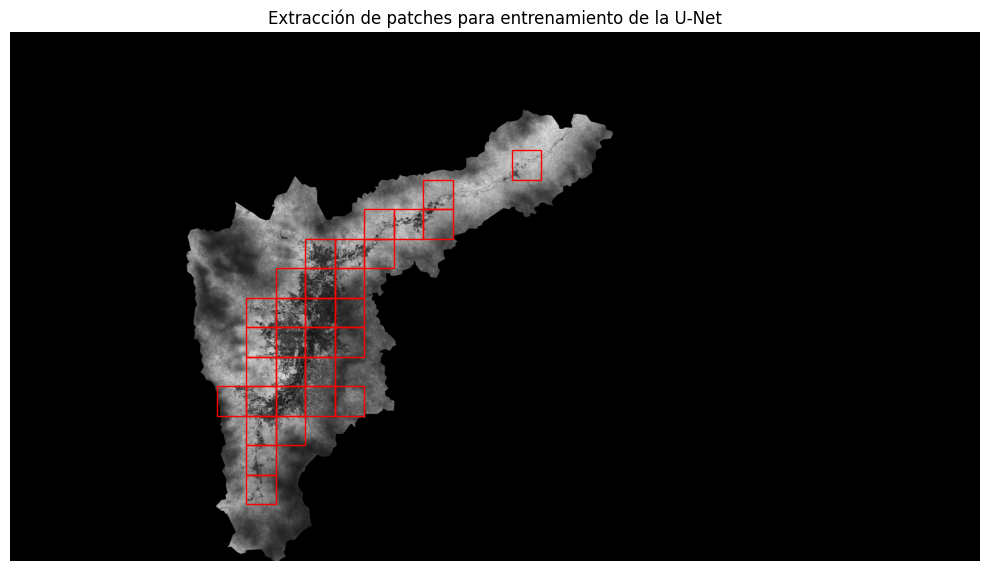

In [20]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

base_img = img_norm[..., 0]

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(base_img, cmap="gray")
ax.set_title("Extracción de patches para entrenamiento de la U-Net")

N_rect = min(50, len(selected_positions))

for k in range(N_rect):
    i, j = selected_positions[k]
    rect = Rectangle(
        (j, i),
        patch_size,
        patch_size,
        linewidth=1.0,
        edgecolor="red",
        facecolor="none"
    )
    ax.add_patch(rect)

plt.axis("off")
plt.tight_layout()
plt.show()


In [21]:
import matplotlib.pyplot as plt
import os

salida_figs = os.path.join(base, "ejemplos_patches_unet")
os.makedirs(salida_figs, exist_ok=True)


num_ejemplos = min(5, X_patches.shape[0])

for idx in range(num_ejemplos):
    patch_img = X_patches[idx]
    patch_mask = Y_patches[idx,...,0]


    rgb = patch_img.copy()
    rgb = np.clip(rgb, 0, 1)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0].imshow(rgb)
    axes[0].set_title("Patch de entrada\n(NDVI–LST–NDBI)")
    axes[0].axis("off")

    axes[1].imshow(patch_mask, cmap="gray")
    axes[1].set_title("Máscara objetivo\n(urbano / no urbano)")
    axes[1].axis("off")

    plt.tight_layout()

    out_fig = os.path.join(salida_figs, f"patch_unet_{idx+1}.png")
    plt.savefig(out_fig, dpi=300)
    plt.close(fig)

    print("Figura guardada:", out_fig)


Figura guardada: /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/ejemplos_patches_unet/patch_unet_1.png
Figura guardada: /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/ejemplos_patches_unet/patch_unet_2.png
Figura guardada: /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/ejemplos_patches_unet/patch_unet_3.png
Figura guardada: /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/ejemplos_patches_unet/patch_unet_4.png
Figura guardada: /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/ejemplos_patches_unet/patch_unet_5.png


# MODELO 4 – DeepLabv3+

In [22]:
!pip install -q torch torchvision

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models

import numpy as np
import rasterio
import os


In [23]:

print("X_patches:", X_patches.shape, "Y_patches:", Y_patches.shape)

Yp = Y_patches[..., 0].astype(np.int64)

# División train / val
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_patches, Yp,
    test_size=0.2,
    random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Val:",   X_val.shape,   y_val.shape)


X_patches: (31, 128, 128, 3) Y_patches: (31, 128, 128, 1)
Train: (24, 128, 128, 3) (24, 128, 128)
Val: (7, 128, 128, 3) (7, 128, 128)


Dataset y DataLoader

In [24]:

class PatchDataset(Dataset):
    """
    Dataset simple para patches de segmentación binaria.
    - X: (N, H, W, C) float32 en [0,1]
    - y: (N, H, W) int64 con valores 0 o 1
    """
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).permute(0, 3, 1, 2).float()
        self.y = torch.from_numpy(y).long()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = PatchDataset(X_train, y_train)
val_ds   = PatchDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False)

len(train_ds), len(val_ds)


(24, 7)

Definir DeepLabv3+ adaptado a NDVI–LST–NDBI

In [25]:

def get_deeplab_3ch(num_classes=2):
    """
    Carga DeepLabv3+ con backbone ResNet-50 preentrenado en ImageNet,
    adapta la primera conv para 3 canales NDVI-LST-NDBI
    y cambia el clasificador para 2 clases (urbano / no urbano).
    """

    model = models.segmentation.deeplabv3_resnet50(weights=models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT)


    old_conv = model.backbone.conv1
    new_conv = nn.Conv2d(
        in_channels=3,
        out_channels=old_conv.out_channels,
        kernel_size=old_conv.kernel_size,
        stride=old_conv.stride,
        padding=old_conv.padding,
        bias=False
    )


    with torch.no_grad():
        new_conv.weight[:] = old_conv.weight

    model.backbone.conv1 = new_conv


    model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

deeplab = get_deeplab_3ch(num_classes=2).to(device)


Device: cpu
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


100%|██████████| 161M/161M [00:02<00:00, 59.0MB/s]


Entrenamiento DeepLabv3

In [26]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(deeplab.parameters(), lr=1e-4)

def evaluate_epoch(model, loader, device):
    model.eval()
    total_loss = 0.0
    total_pixels = 0
    total_correct = 0

    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(device)
            yb = yb.to(device)

            out = model(Xb)['out']
            loss = criterion(out, yb)

            total_loss += loss.item() * Xb.size(0)


            preds = out.argmax(dim=1)
            total_correct += (preds == yb).sum().item()
            total_pixels  += yb.numel()

    avg_loss = total_loss / len(loader.dataset)
    acc = total_correct / total_pixels
    return avg_loss, acc


num_epochs = 10
for epoch in range(1, num_epochs+1):
    deeplab.train()
    total_loss = 0.0

    for Xb, yb in train_loader:
        Xb = Xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        out = deeplab(Xb)['out']
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * Xb.size(0)

    train_loss = total_loss / len(train_loader.dataset)
    val_loss, val_acc = evaluate_epoch(deeplab, val_loader, device)

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} "
          f"| val_loss={val_loss:.4f} | val_acc={val_acc:.4f}")


Epoch 01 | train_loss=0.6723 | val_loss=0.6089 | val_acc=0.7842
Epoch 02 | train_loss=0.5866 | val_loss=0.5240 | val_acc=0.7857
Epoch 03 | train_loss=0.5229 | val_loss=0.5157 | val_acc=0.7971
Epoch 04 | train_loss=0.4817 | val_loss=0.5769 | val_acc=0.7930
Epoch 05 | train_loss=0.4703 | val_loss=0.5115 | val_acc=0.7886
Epoch 06 | train_loss=0.4145 | val_loss=0.5018 | val_acc=0.7979
Epoch 07 | train_loss=0.4082 | val_loss=0.4496 | val_acc=0.8057
Epoch 08 | train_loss=0.3916 | val_loss=0.4078 | val_acc=0.8278
Epoch 09 | train_loss=0.3606 | val_loss=0.4572 | val_acc=0.8281
Epoch 10 | train_loss=0.3549 | val_loss=0.5257 | val_acc=0.8258


**GUARDAR EL MODELO**

In [27]:
model_path = os.path.join(base, "deeplab_urbano_2023.pth")
torch.save(deeplab.state_dict(), model_path)
print("Modelo DeepLab guardado en:", model_path)


Modelo DeepLab guardado en: /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/deeplab_urbano_2023.pth


Inferencia sobre toda la imagen y mapa urbano DeepLab

In [28]:
deeplab.eval()

H, W, C = img_norm.shape
pred_full = np.zeros((H, W), dtype=np.uint8)

patch_size = 128

with torch.no_grad():
    for i in range(0, H, patch_size):
        for j in range(0, W, patch_size):

            if i + patch_size > H or j + patch_size > W:
                continue

            patch = img_norm[i:i+patch_size, j:j+patch_size, :]
            patch_tensor = torch.from_numpy(patch).permute(2,0,1).unsqueeze(0).float().to(device)

            out = deeplab(patch_tensor)['out']
            pred = out.argmax(dim=1).squeeze(0).cpu().numpy().astype(np.uint8)

            pred_full[i:i+patch_size, j:j+patch_size] = pred

pred_full[~valid_mask] = 0

np.unique(pred_full)


array([0, 1], dtype=uint8)

GUARDAR RASTER

In [29]:

deeplab_out_path = os.path.join(base, "urbano_DeepLab_2023.tif")

profile_dl = profile.copy()
profile_dl.update(
    dtype="uint8",
    count=1,
    nodata=0
)

with rasterio.open(deeplab_out_path, "w", **profile_dl) as dst:
    dst.write(pred_full, 1)

print("Mapa urbano/no urbano DeepLab guardado como:", deeplab_out_path)


Mapa urbano/no urbano DeepLab guardado como: /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/urbano_DeepLab_2023.tif


# Referencia WorldCover

In [31]:
import os, rasterio, numpy as np

base = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES"

world_paths = {
    "URBANOrobust": os.path.join(base, "worldcover_2020_300m_URBANOrobust.tif"),
    "WC_32618_aligned": os.path.join(base, "worldcover_2020_300m_32618_aligned.tif"),
    "BUILTUP_aligned": os.path.join(base, "worldcover_2020_300m_aligned_BUILTUP.tif"),
}

for name, p in world_paths.items():
    with rasterio.open(p) as src:
        arr = src.read(1)
        nodata = src.nodata
        vals = arr[arr != nodata]
        print(f" {name}")
        print("  path      :", p)
        print("  CRS       :", src.crs)
        print("  Res       :", src.res)
        print("  Shape     :", src.height, "x", src.width)
        print("  Nnodata   :", np.sum(arr == nodata) if nodata is not None else 0)
        print("  Valores únicos (muestra):", np.unique(vals)[:10])
        print("-"*60)


 URBANOrobust
  path      : /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/worldcover_2020_300m_URBANOrobust.tif
  CRS       : EPSG:32618
  Res       : (307.173442660929, 307.173442660929)
  Shape     : 194 x 182
  Nnodata   : 0
  Valores únicos (muestra): [0 1]
------------------------------------------------------------
 WC_32618_aligned
  path      : /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/worldcover_2020_300m_32618_aligned.tif
  CRS       : EPSG:32618
  Res       : (307.173442660929, 307.173442660929)
  Shape     : 194 x 182
  Nnodata   : 0
  Valores únicos (muestra): [ 0 10 20 30 40 50 60 80]
------------------------------------------------------------
 BUILTUP_aligned
  path      : /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/worldcover_2020_300m_aligned_BUILTUP.tif
  CRS       : EPSG:32618
  Res 

In [32]:
ref_path      = os.path.join(base, "worldcover_2020_300m_aligned_BUILTUP.tif")

baseline_path = os.path.join(base, "urbano_baseline_2023.tif")
rf_path       = os.path.join(base, "urbano_RF_2023.tif")
unet_path     = os.path.join(base, "urbano_UNet_2023.tif")
deeplab_path  = os.path.join(base, "urbano_DeepLab_2023.tif")


In [33]:
import numpy as np
import rasterio
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def eval_model(pred_path, ref_path):
    """
    Compara un mapa predicho con WorldCover 2020 binario (0/1).
    Retorna: accuracy, precision, recall, f1, IoU urbano.
    """
    with rasterio.open(ref_path) as src:
        ref = src.read(1)
        nodata_ref = src.nodata

    with rasterio.open(pred_path) as src:
        pred = src.read(1)
        nodata_pred = src.nodata


    mask = np.ones_like(ref, dtype=bool)
    if nodata_ref is not None:
        mask &= (ref != nodata_ref)
    if nodata_pred is not None:
        mask &= (pred != nodata_pred)

    y_true = ref[mask].ravel()
    y_pred = pred[mask].ravel()

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    intersection = np.logical_and(y_true == 1, y_pred == 1).sum()
    union        = np.logical_or( y_true == 1, y_pred == 1).sum()
    iou = intersection / union if union > 0 else 0.0

    return acc, prec, rec, f1, iou


In [34]:
import os
import rasterio
import numpy as np
from rasterio.warp import reproject, Resampling

base = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES"


wc_coarse_path = os.path.join(base, "worldcover_2020_300m_aligned_BUILTUP.tif")


unet_path = os.path.join(base, "urbano_UNet_2023.tif")


wc_30m_path = os.path.join(base, "worldcover_2020_BUILTUP_30m.tif")

with rasterio.open(wc_coarse_path) as src_wc, rasterio.open(unet_path) as src_ref:
    print("WorldCover 300m ->", src_wc.crs, src_wc.res, src_wc.height, src_wc.width)
    print("Referencia 30m   ->", src_ref.crs, src_ref.res, src_ref.height, src_ref.width)


    profile = src_ref.profile.copy()
    profile.update(
        dtype=src_wc.dtypes[0],
        count=1,
        nodata=src_wc.nodata
    )


    dst = np.empty((src_ref.height, src_ref.width), dtype=src_wc.dtypes[0])

    reproject(
        source=rasterio.band(src_wc, 1),
        destination=dst,
        src_transform=src_wc.transform,
        src_crs=src_wc.crs,
        dst_transform=src_ref.transform,
        dst_crs=src_ref.crs,
        resampling=Resampling.nearest
    )

    with rasterio.open(wc_30m_path, "w", **profile) as dst_src:
        dst_src.write(dst, 1)

print("WorldCover BUILTUP reescalado guardado en:", wc_30m_path)


WorldCover 300m -> EPSG:32618 (307.173442660929, 307.173442660929) 194 182
Referencia 30m   -> EPSG:32618 (30.0, 30.0) 2294 4209
WorldCover BUILTUP reescalado guardado en: /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/worldcover_2020_BUILTUP_30m.tif


# Evaluar Baseline, RF, U-Net y DeepLab contra WorldCover 2020

In [35]:
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def eval_model_resample(pred_path, ref_path):
    """
    Compara un mapa predicho con un mapa de referencia binario (0/1).
    Si las formas o el transform no coinciden, remuestrea la referencia
    al grid del mapa predicho usando 'nearest'.
    Retorna: accuracy, precision, recall, f1, IoU urbano.
    """

    with rasterio.open(pred_path) as src_pred:
        pred = src_pred.read(1)
        nodata_pred = src_pred.nodata
        dst_crs = src_pred.crs
        dst_transform = src_pred.transform
        dst_shape = pred.shape


    with rasterio.open(ref_path) as src_ref:
        ref = src_ref.read(1)
        nodata_ref = src_ref.nodata
        src_crs = src_ref.crs
        src_transform = src_ref.transform
        src_shape = ref.shape


    if src_shape != dst_shape or src_crs != dst_crs or src_transform != dst_transform:
        ref_resampled = np.empty(dst_shape, dtype=ref.dtype)
        reproject(
            source=ref,
            destination=ref_resampled,
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest
        )
        ref = ref_resampled


    mask = np.ones_like(pred, dtype=bool)
    if nodata_ref is not None:
        mask &= (ref != nodata_ref)
    if nodata_pred is not None:
        mask &= (pred != nodata_pred)

    y_true = ref[mask].ravel()
    y_pred = pred[mask].ravel()


    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    intersection = np.logical_and(y_true == 1, y_pred == 1).sum()
    union        = np.logical_or( y_true == 1, y_pred == 1).sum()
    iou = intersection / union if union > 0 else 0.0

    return acc, prec, rec, f1, iou


In [36]:
base = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES"

ref_path      = os.path.join(base, "worldcover_2020_300m_aligned_BUILTUP.tif")  # o el que quieras usar
baseline_path = os.path.join(base, "urbano_baseline_2023.tif")
rf_path       = os.path.join(base, "urbano_RF_2023.tif")
unet_path     = os.path.join(base, "urbano_UNet_2023.tif")
deeplab_path  = os.path.join(base, "urbano_DeepLab_2023.tif")

for name, p in [
    ("Baseline",      baseline_path),
    ("Random Forest", rf_path),
    ("U-Net",         unet_path),
    ("DeepLabv3+",    deeplab_path),
]:
    acc, prec, rec, f1, iou = eval_model_resample(p, ref_path)
    print(f"{name:12s} | acc={acc:.3f} | prec={prec:.3f} | rec={rec:.3f} "
          f"| f1={f1:.3f} | IoU_urb={iou:.3f}")


Baseline     | acc=0.975 | prec=0.975 | rec=1.000 | f1=0.987 | IoU_urb=0.975
Random Forest | acc=0.975 | prec=0.975 | rec=1.000 | f1=0.987 | IoU_urb=0.975
U-Net        | acc=0.987 | prec=0.987 | rec=1.000 | f1=0.993 | IoU_urb=0.987
DeepLabv3+   | acc=0.994 | prec=0.994 | rec=1.000 | f1=0.997 | IoU_urb=0.994


In [37]:
import rasterio
import numpy as np
import os

base = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES"

path_LST  = os.path.join(base, "LST_2023_Reproyectado.tif")
path_NDVI = os.path.join(base, "NDVI_2023_32618_30m.tif")
path_NDBI = os.path.join(base, "ndbi_reproyectado.tif")

def load_and_normalize(path):
    with rasterio.open(path) as src:
        arr = src.read(1).astype(float)
        nod = src.nodata
        mask = (arr != nod) & (~np.isnan(arr))
        arr_min, arr_max = arr[mask].min(), arr[mask].max()


        arr_norm = (arr - arr_min) / (arr_max - arr_min)
        arr_norm[~mask] = 0
    return arr_norm

lst_norm  = load_and_normalize(path_LST)
ndvi_norm = load_and_normalize(path_NDVI)
ndbi_norm = load_and_normalize(path_NDBI)

print("Shapes -> LST:", lst_norm.shape, "NDVI:", ndvi_norm.shape, "NDBI:", ndbi_norm.shape)


Shapes -> LST: (2294, 4209) NDVI: (2294, 4209) NDBI: (2294, 4209)


In [38]:
img_rgb = np.dstack([ndvi_norm, lst_norm, ndbi_norm])
img_rgb = np.clip(img_rgb, 0, 1)


(np.float64(-0.5), np.float64(4208.5), np.float64(2293.5), np.float64(-0.5))

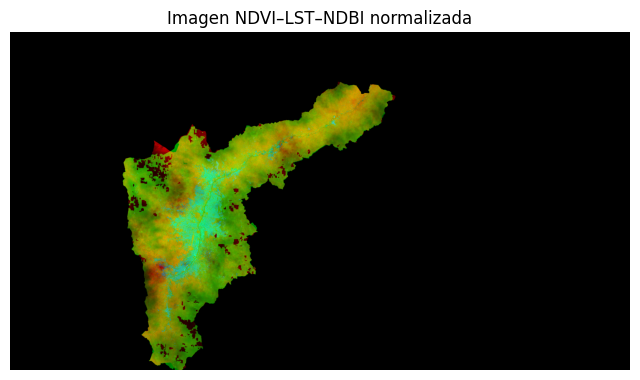

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.imshow(img_rgb)
plt.title("Imagen NDVI–LST–NDBI normalizada")
plt.axis("off")


In [40]:
import numpy as np

patch_size = 128

coords_unet = []
coords_DL = []

H, W, _ = img_rgb.shape

for y in range(0, H - patch_size, patch_size):
    for x in range(0, W - patch_size, patch_size):
        coords_unet.append((y, x))


In [41]:
coords_DL = coords_unet
X_patches_DL = X_patches
y_patches_DL = Y_patches[..., 0]


In [42]:
img_rgb = np.dstack([ndvi_norm, lst_norm, ndbi_norm])
img_rgb = np.clip(img_rgb, 0, 1)


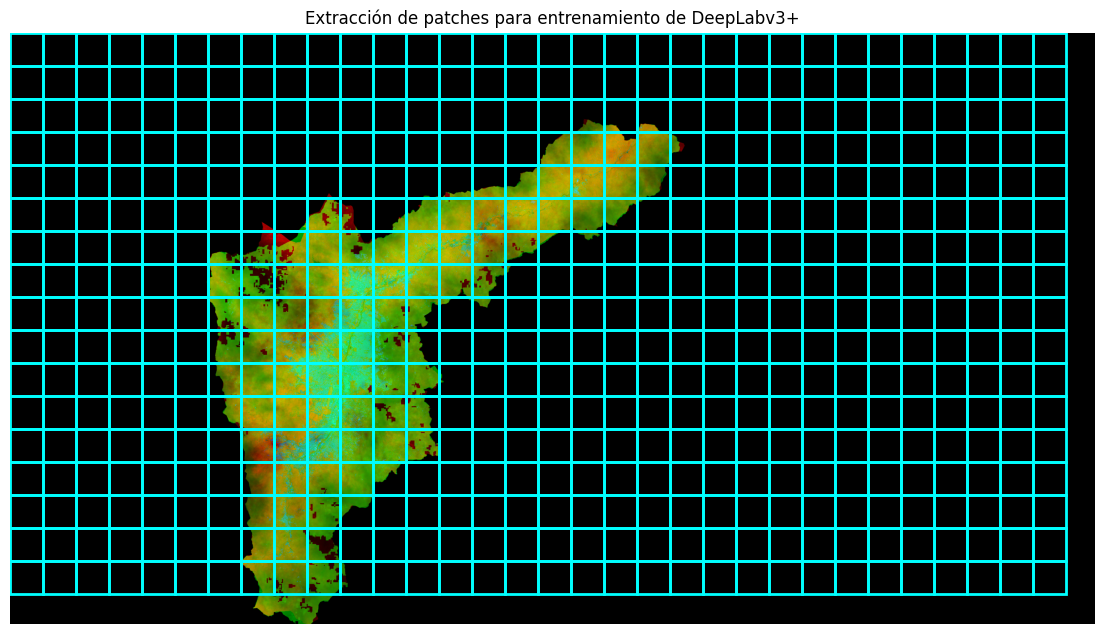

In [43]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.figure(figsize=(14, 8))
plt.imshow(img_rgb)
plt.title("Extracción de patches para entrenamiento de DeepLabv3+")
plt.axis("off")

for (y, x) in coords_DL:
    rect = patches.Rectangle(
        (x, y), patch_size, patch_size,
        linewidth=2, edgecolor='cyan', facecolor='none'
    )
    plt.gca().add_patch(rect)

plt.show()


In [44]:
whos


Variable                 Type                      Data/Info
------------------------------------------------------------
C                        int                       3
DataLoader               type                      <class 'torch.utils.data.dataloader.DataLoader'>
Dataset                  type                      <class 'torch.utils.data.dataset.Dataset'>
H                        int                       2294
N_max                    int                       100000
N_rect                   int                       31
PatchDataset             type                      <class '__main__.PatchDataset'>
RandomForestClassifier   ABCMeta                   <class 'sklearn.ensemble.<...>.RandomForestClassifier'>
Rectangle                type                      <class 'matplotlib.patches.Rectangle'>
Resampling               EnumType                  <enum 'Resampling'>
W                        int                       4209
X                        ndarray                   11076

In [47]:
import os
import matplotlib.pyplot as plt

X_data = X_patches_DL
Y_data = y_patches_DL

save_dir = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/patches_ejemplo_DeepLab"
os.makedirs(save_dir, exist_ok=True)

num_examples = min(5, len(X_data))

for i in range(num_examples):
    x = X_data[i]
    y = Y_data[i]

    # --- Patch de entrada ---
    plt.figure(figsize=(3,3))
    plt.imshow(x)
    plt.axis("off")
    plt.title(f"Patch entrada #{i}")
    plt.savefig(f"{save_dir}/patch_DL_{i}_input.png", dpi=300, bbox_inches="tight")
    plt.close()

    # --- Máscara objetivo ---
    plt.figure(figsize=(3,3))
    plt.imshow(y, cmap="gray")
    plt.axis("off")
    plt.title(f"Máscara #{i}")
    plt.savefig(f"{save_dir}/patch_DL_{i}_mask.png", dpi=300, bbox_inches="tight")
    plt.close()

print("Parches DeepLab guardados en:", save_dir)


Parches DeepLab guardados en: /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/patches_ejemplo_DeepLab


In [48]:
import os
import matplotlib.pyplot as plt


X_data = X_patches_DL
Y_data = y_patches_DL

save_dir = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/patches_ejemplo_DeepLab"
os.makedirs(save_dir, exist_ok=True)

num_examples = min(5, len(X_data))

for i in range(num_examples):
    x = X_data[i]
    y = Y_data[i]

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # --- Entrada ---
    axes[0].imshow(x)
    axes[0].set_title(f"Patch de entrada #{i}\n(NDVI–LST–NDBI)")
    axes[0].axis("off")

    # --- Máscara ---
    axes[1].imshow(y, cmap="gray")
    axes[1].set_title(f"Máscara urbana #{i}")
    axes[1].axis("off")


    out_path = f"{save_dir}/patch_DL_{i}.png"
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close()

print("Parches combinados (input + máscara) guardados en:", save_dir)


Parches combinados (input + máscara) guardados en: /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/patches_ejemplo_DeepLab
